# Setup

In [1]:
# from datetime import datetime
import os, glob, re
import numpy as np
import pandas as pd
import warnings
from math import sqrt

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'colab'

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import pymc as pm
import arviz as az

# import optuna

# from scipy.stats import uniform, randint
# from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# import tensorflow as tf

# data Table Display
%load_ext google.colab.data_table

# to make this notebook's output stable across runs
np.random.seed(42)

In [2]:
# mount google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load  dataset
df = pd.read_csv('/content/drive/MyDrive/[04] Colab Notebooks/data/weekly_media_sample.csv')
df['DATE'] = pd.to_datetime(df['DATE'])

In [4]:
df.head(5)

,X,DATE,revenue,media1_S,media2_S,media3_S,competitor_sales,newsletter
0,1,2012-08-06,2.754372e+06,167687.6,95463.666667,228213.987444,8125009,19401.65
1,2,2012-08-13,2.584277e+06,214600.9,0.000000,34258.573511,7901549,14791.00
2,3,2012-08-20,2.547387e+06,0.0,3404.000000,127691.261335,8300197,14544.00
3,4,2012-08-27,2.875220e+06,625877.3,132600.000000,84014.720306,8122883,2800.00
4,5,2012-09-03,2.215953e+06,0.0,0.000000,20687.478156,7105985,15478.00


In [5]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.DATE, y=df.revenue, name='Revenue', line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df.DATE, y=df.competitor_sales, name='Competitor Sales', line=dict(color='red', width=.8)))
fig.add_trace(go.Scatter(x=df.DATE, y=df.newsletter, name='Newsletter Subscription', line=dict(color='green', width=.8)))
fig.show()

# Part 1: Classical Marketing Data Modelling

In [6]:
# Creating a subset of dataframe for modelling
# df2 = df[['DATE','revenue','media1_S','media2_S','media3_S','competitor_sales','newsletter']].copy()
df2 = df[['DATE','revenue','media1_S','competitor_sales','newsletter']].copy()

In [7]:
# Calculate correlation coefficients with the target variable 'revenue'
correlation_matrix = df2.corr()
correlation_with_revenue = correlation_matrix['revenue'].abs().sort_values(ascending=False)

# Print the correlation coefficients
print(correlation_with_revenue)

revenue             1.000000
competitor_sales    0.916454
media1_S            0.419869
newsletter          0.406099
Name: revenue, dtype: float64


In [ ]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix,mask = mask, cmap=cmap, annot=True)

In [ ]:
# Define the split date based on the given threshold (e.g., '2016-05-30' in this case)
split_date = '2016-05-30'

# Split the data into train and test sets
train = df2[df2.DATE <= split_date]
test = df2[df2.DATE > split_date]

# Extract the target variable 'revenue' from the training and test data
y_train = train['revenue']
y_test = test['revenue']

# Extract the input features from the training and test data
X_train = train.drop(['revenue', 'DATE'], axis=1)
X_test = test.drop(['revenue', 'DATE'], axis=1)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create instances of regression models with hyperparameters
linear_reg = LinearRegression()
sgd_reg = SGDRegressor()
# svm_reg = SVR(C=10, degree=3, gamma='auto', kernel='rbf')
# gaussian_process_reg = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel())
random_forest_reg = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
gradient_boosting_reg = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=20, random_state=42)
mlp_reg = MLPRegressor(hidden_layer_sizes=(500, 300, 200), batch_size=64, learning_rate='adaptive', alpha=0.1, max_iter=5000, random_state=42)

# Create DataFrames to store predicted values
train_predictions_df = pd.DataFrame(data=y_train.values, columns=['Actual Revenue'])
test_predictions_df = pd.DataFrame(data=y_test.values, columns=['Actual Revenue'])

results_df = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'R2', 'MAPE'])

# Mean Absolute Percentage Error (MAPE) function
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to evaluate and append results to the DataFrame
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_predictions_df[model_name] = y_train_pred
    test_predictions_df[model_name] = y_test_pred
    rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    results_df.loc[len(results_df)] = [model_name, rmse, mae, r2, mape]

# Evaluate each model and store the results
evaluate_model('Linear Regression', linear_reg, X_train, y_train, X_test, y_test)
evaluate_model('Stochastic Gradient Descent', sgd_reg, X_train, y_train, X_test, y_test)
# evaluate_model('SVM', svm_reg, X_train, y_train, X_test, y_test)
# evaluate_model('Gaussian Processes', gaussian_process_reg, X_train, y_train, X_test, y_test)
evaluate_model('Random Forest', random_forest_reg, X_train, y_train, X_test, y_test)
evaluate_model('Gradient Boosting', gradient_boosting_reg, X_train, y_train, X_test, y_test)
evaluate_model('Multi-layer Perceptron', mlp_reg, X_train, y_train, X_test, y_test)

In [ ]:
results_df.head()

In [54]:
# Print the coefficient of the linear regression
linear_reg.coef_

array([112513.37030082, 611400.75603055,  12931.4536216 ])

In [56]:
# Merge train_predictions_df and test_predictions_df while keeping 'DATE' column
merged_predictions_df = pd.concat([train_predictions_df, test_predictions_df])

# Add the 'DATE' column from df2 to merged_predictions_df
merged_predictions_df['DATE'] = np.sort(df2['DATE'])

# Create a trace for each model's predicted values against the actual 'revenue'
traces = []
for column in merged_predictions_df.columns[:-1]:  # Exclude the first and last columns ('Actual Revenue' and 'DATE')
    trace = go.Scatter(
        x=merged_predictions_df['DATE'],
        y=merged_predictions_df[column],
        mode='lines',
        name=column
    )
    traces.append(trace)

# Create the layout for the plot
layout = go.Layout(
    title='Actual vs. Predicted Revenue',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Revenue'),
)

# Create the figure and plot
fig = go.Figure(data=traces, layout=layout)
fig.show()

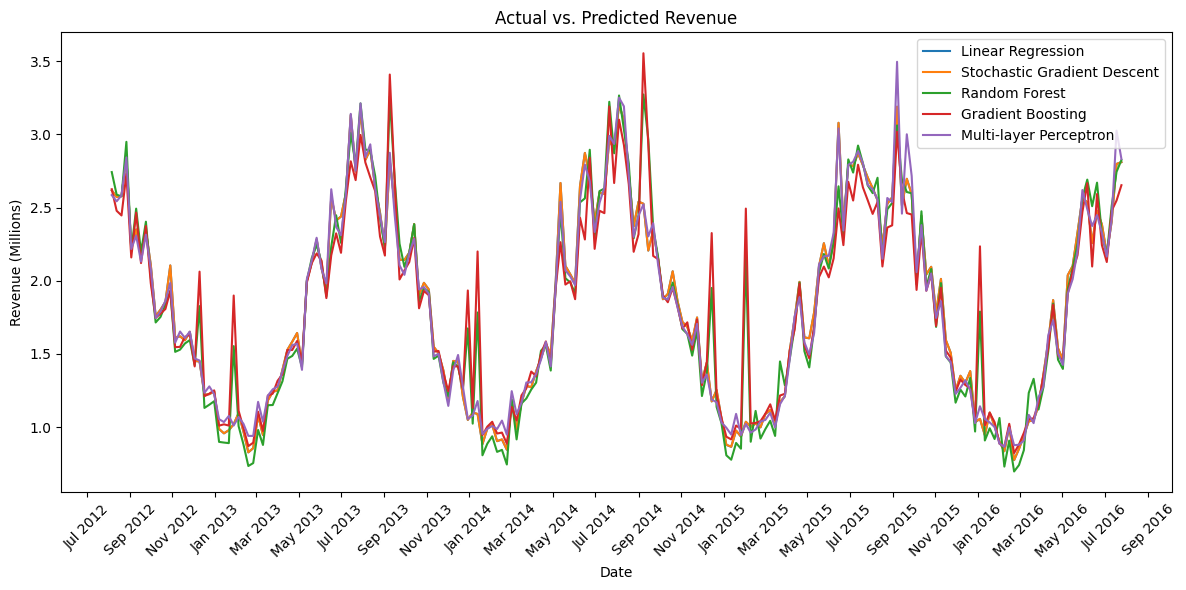

In [57]:
# Convert 'DATE' column to datetime object
# merged_predictions_df['DATE'] = pd.to_datetime(merged_predictions_df['DATE'])

# Create a line chart for each model's predicted values against the actual 'revenue' over time
plt.figure(figsize=(12, 6))
for column in merged_predictions_df.columns[1:-1]:  # Exclude the first and last columns ('Actual Revenue' and 'DATE')
    plt.plot(merged_predictions_df['DATE'], merged_predictions_df[column], label=column)

# Set the x-axis label to 'Date' and y-axis label to 'Revenue'
plt.xlabel('Date')
plt.ylabel('Revenue (Millions)')

# Set the title of the plot
plt.title('Actual vs. Predicted Revenue')

# Show the legend to identify each model's line
plt.legend()

# Format x-axis date labels to show only the month and year
date_format = mdates.DateFormatter("%b %Y")
plt.gca().xaxis.set_major_formatter(date_format)

# Set the x-axis tick interval to show labels every n months (adjust n as needed)
n_months = 2
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=n_months))

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Format y-axis tick labels in millions
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}'

formatter = FuncFormatter(millions_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Show the plot
plt.tight_layout()
plt.show()

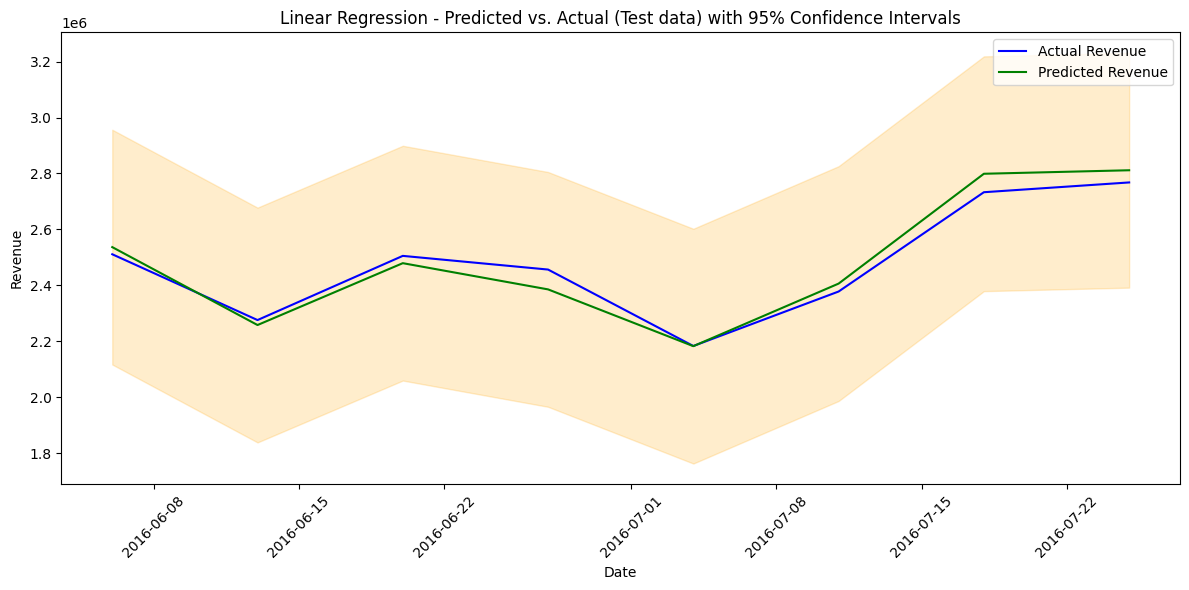

In [59]:
# Fit the Linear Regression model
linear_reg.fit(X_train, y_train)

# Predict on the test set
Y_pred_linear = linear_reg.predict(X_test)

# Calculate the 95% confidence intervals for the predictions
conf_interval_linear = 1.96 * np.std(Y_pred_linear)  # 1.96 is the z-score for 95% confidence

# # Create a DataFrame with predictions and confidence intervals for the last 20 rows
# df_pred_linear = pd.DataFrame({'DATE': df2['DATE'].tail(8).values,
#                                'Actual Revenue': y_test[-8:].values.flatten(),
#                                'Predicted Revenue': Y_pred_linear[-8:].flatten(),
#                                'Lower CI': (Y_pred_linear[-8:] - conf_interval_linear).flatten(),
#                                'Upper CI': (Y_pred_linear[-8:] + conf_interval_linear).flatten()})

# Create a DataFrame with predictions and confidence intervals for the last 20 rows
df_pred_linear = pd.DataFrame({'DATE': df2['DATE'].tail(8).values,
                               'Actual Revenue': y_test.values.flatten(),
                               'Predicted Revenue': Y_pred_linear.flatten(),
                               'Lower CI': (Y_pred_linear - conf_interval_linear).flatten(),
                               'Upper CI': (Y_pred_linear + conf_interval_linear).flatten()})

# Plot the last 20 rows of predictions, actual observations, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(df2['DATE'].tail(8), df2['revenue'].tail(8), label='Actual Revenue', color='blue')
plt.plot(df_pred_linear['DATE'], df_pred_linear['Predicted Revenue'], label='Predicted Revenue', color='green')
plt.fill_between(df_pred_linear['DATE'], df_pred_linear['Lower CI'], df_pred_linear['Upper CI'], alpha=0.2, color='orange')
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Linear Regression - Predicted vs. Actual (Test data) with 95% Confidence Intervals")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## ARIMA

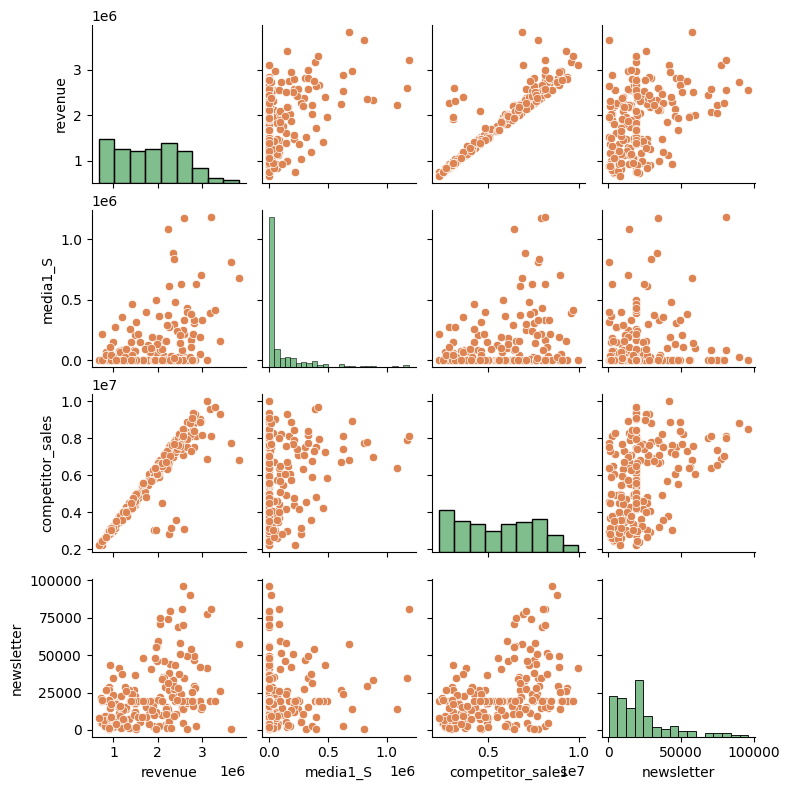

In [130]:
sns_c = sns.color_palette(palette="deep")

sns.pairplot(
    data=df2, kind="scatter", height=2, plot_kws={"color": sns_c[1]}, diag_kws={"color": sns_c[2]}
);

<Figure size 1200x600 with 0 Axes>

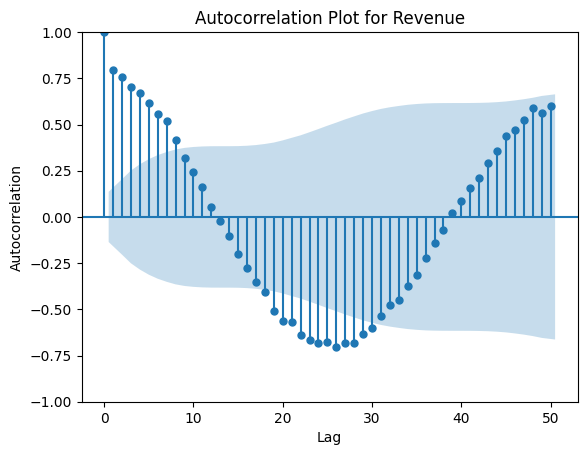

<Figure size 1200x600 with 0 Axes>

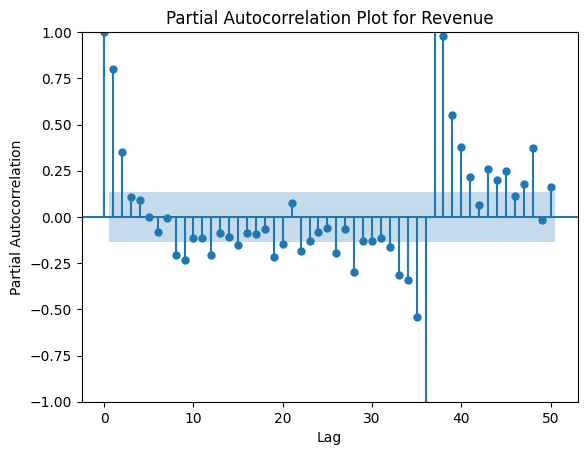

In [60]:
plt.figure(figsize=(12, 6))
plot_acf(df2['revenue'], lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot for Revenue')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df2['revenue'], lags=50)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot for Revenue')
plt.show()

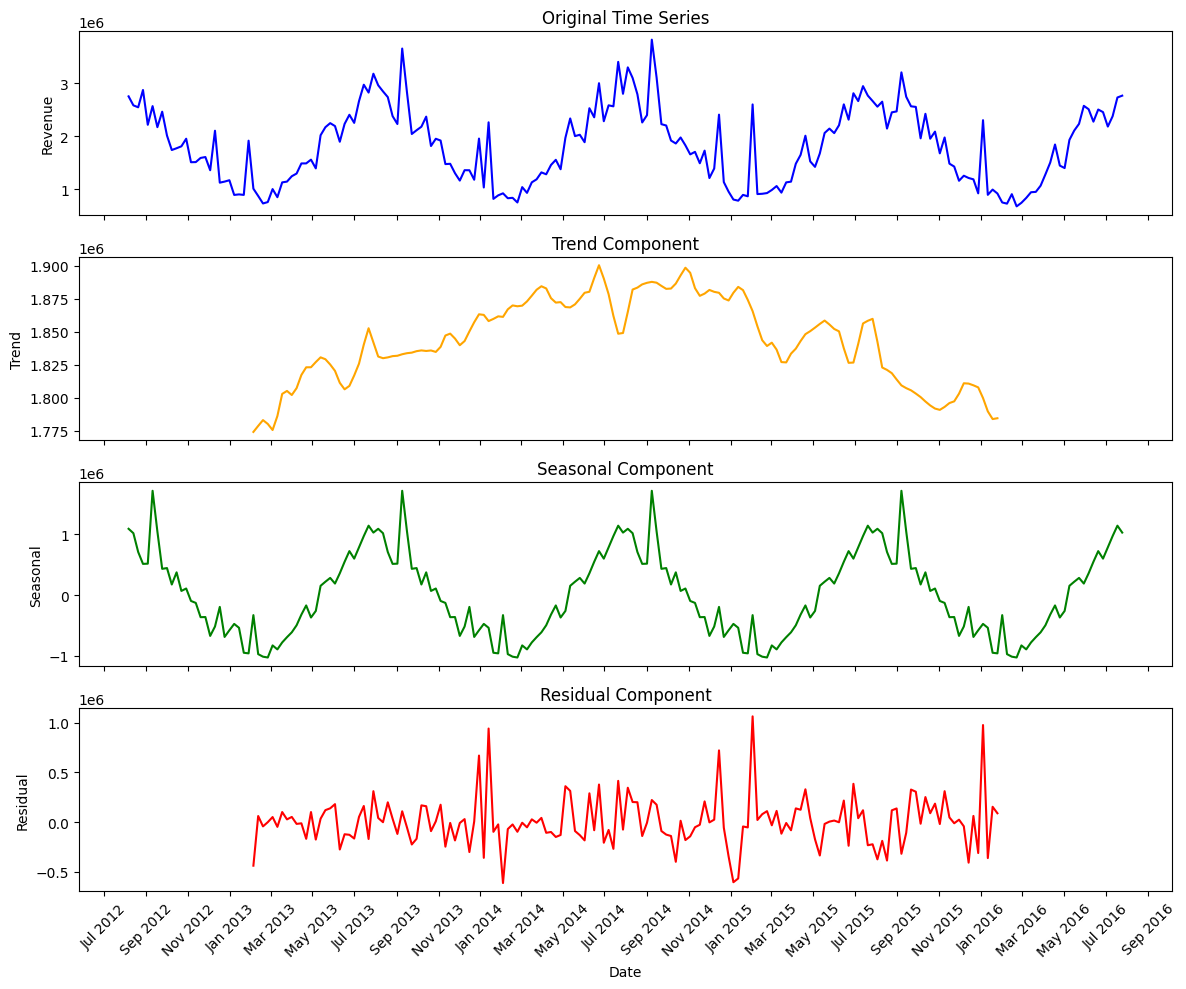

In [61]:
# Performing seasonal decomposition
result = seasonal_decompose(df2['revenue'], model='additive', period=52)  # Assuming weekly seasonality (period=52)

# Creating a subplot layout
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plotting the original time series
axes[0].plot(df2['DATE'], df2['revenue'], label='Original', color='blue')
axes[0].set_ylabel('Revenue')
axes[0].set_title('Original Time Series')

# Plotting the trend component
axes[1].plot(df2['DATE'], result.trend, label='Trend', color='orange')
axes[1].set_ylabel('Trend')
axes[1].set_title('Trend Component')

# Plotting the seasonal component
axes[2].plot(df2['DATE'], result.seasonal, label='Seasonal', color='green')
axes[2].set_ylabel('Seasonal')
axes[2].set_title('Seasonal Component')

# Plotting the residual component
axes[3].plot(df2['DATE'], result.resid, label='Residual', color='red')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Residual')
axes[3].set_title('Residual Component')

# Format x-axis date labels to show only the month and year
date_format = mdates.DateFormatter("%b %Y")
axes[-1].xaxis.set_major_formatter(date_format)

# Set the x-axis tick interval to show labels every n months (adjust n as needed)
n_months = 2
axes[-1].xaxis.set_major_locator(mdates.MonthLocator(interval=n_months))

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Adjusting the layout
plt.tight_layout()

# Show the plot
plt.show()

In [62]:
# Perform the ADF test on the 'revenue' data
result = adfuller(df2['revenue'])

# Extract the test statistic and p-value
test_statistic = result[0]
p_value = result[1]

print("ADF Test Statistic:", test_statistic)
print("p-value:", p_value)

if p_value <= 0.05:
    print("The data is stationary.")
else:
    print("The data is not stationary.")

ADF Test Statistic: -5.736818231618179
p-value: 6.409872248182059e-07
The data is stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converg

Best ARIMA Order (p, d, q): (12, 1, 2)
ARIMA RMSE: 217787.2431688691


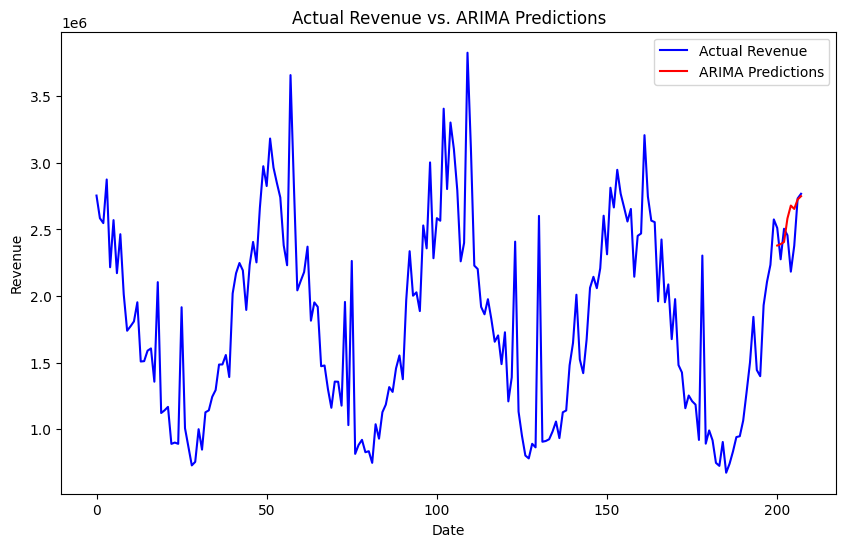

In [63]:
# Find the optimal ARIMA hyperparameters using grid search
best_aic = float("inf")
best_order = None

# Define the ranges for p, d, and q
p_range = range(0, 15)  # Example: p can be 0, 1, or 2
d_range = range(0, 2)  # Example: d can be 0 or 1
q_range = range(0, 3)  # Example: q can be 0, 1, or 2

for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                arima_model = ARIMA(train['revenue'], order=(p, d, q))
                arima_fit = arima_model.fit()

                # Calculate AIC score for the current ARIMA model
                aic = arima_fit.aic

                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)

            except:
                continue

# Fit the ARIMA model with the best parameters to the training data
arima_model = ARIMA(train['revenue'], order=best_order)
arima_fit = arima_model.fit()

# Make predictions on the test set
y_pred_arima = arima_fit.forecast(steps=len(test))

# Evaluate the performance using Mean Squared Error (MSE)
mse_arima = mean_squared_error(test['revenue'], y_pred_arima)
rmse_arima = np.sqrt(mse_arima)

print("Best ARIMA Order (p, d, q):", best_order)
print("ARIMA RMSE:", rmse_arima)

# Plot the actual revenue and ARIMA predictions
plt.figure(figsize=(10, 6))
plt.plot(df2.index, df2['revenue'], label='Actual Revenue', color='blue')
plt.plot(test.index, y_pred_arima, label='ARIMA Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Actual Revenue vs. ARIMA Predictions')
plt.legend()
plt.show()

In [64]:
# summary of fit model
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  200
Model:                ARIMA(12, 1, 2)   Log Likelihood               -2831.963
Date:                Tue, 25 Jul 2023   AIC                           5693.925
Time:                        18:44:19   BIC                           5743.325
Sample:                             0   HQIC                          5713.918
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2165      0.094     12.899      0.000       1.032       1.401
ar.L2         -0.1258      0.115     -1.097      0.272      -0.350       0.099
ar.L3         -0.1452      0.145     -1.000      0.3

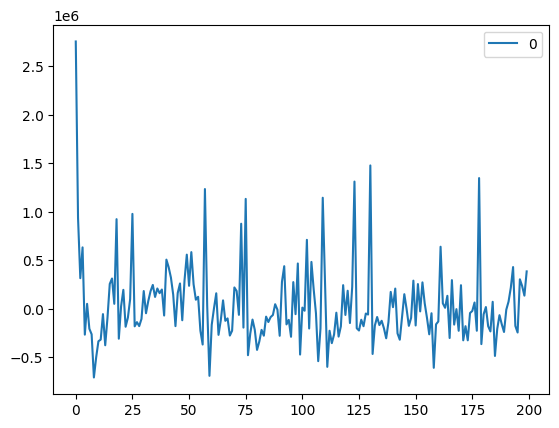

In [65]:
# line plot of residuals
residuals = pd.DataFrame(arima_fit.resid)
residuals.plot()
plt.show()

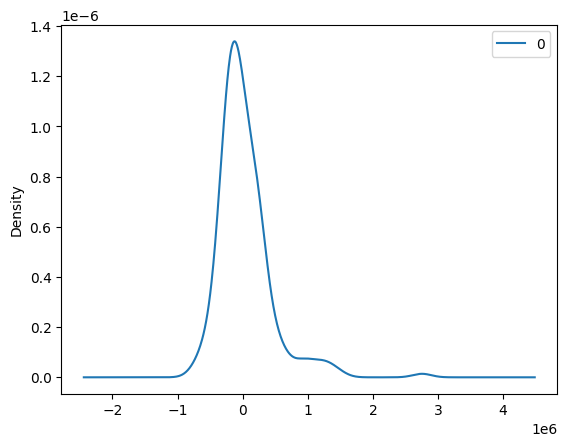

                  0
count  2.000000e+02
mean   3.385575e+04
std    4.113088e+05
min   -7.075360e+05
25%   -2.021622e+05
50%   -5.778437e+04
75%    1.962007e+05
max    2.754372e+06


In [66]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

## Deep learning

In [72]:
def create_time_series_dataset_with_lags(df, threshold_date, lag_observation=5, forecast_horizon=1):
    """
    Create X and Y matrices for time series modeling with lag observations and split into train and test sets.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time series data with columns: revenue, competitor_sales,
                           newsletter, Total_Media_Spend, and DATE.
        threshold_date (str): The date to split the data into train and test sets (format: 'YYYY-MM-DD').
        lag_observation (int): The number of lag observations to use. Default is 5.
        forecast_horizon (int): The number of steps ahead to forecast revenue. Default is 1.

    Returns:
        X_train (np.ndarray): 3-dimensional array containing input features with lag observations for the train set.
        Y_train (np.ndarray): 1-dimensional array containing target values (revenue) for the train set.
        X_test (np.ndarray): 3-dimensional array containing input features with lag observations for the test set.
        y_test (np.ndarray): 1-dimensional array containing target values (revenue) for the test set.
    """
    # Convert threshold_date to Timestamp object
    threshold_date = pd.to_datetime(threshold_date)


    # Get the 'revenue' time series and other features
    revenue = df['revenue'].values
    competitor_sales = df['competitor_sales'].values
    newsletter = df['newsletter'].values
    media1_S = df['media1_S'].values

    X_train, Y_train, X_test, Y_test = [], [], [], []

    for i in range(len(df) - lag_observation - forecast_horizon + 1):
        # Input sequence with lag observations for all features
        x_sequence = np.column_stack((
            revenue[i:i + lag_observation],
            competitor_sales[i:i + lag_observation],
            newsletter[i:i + lag_observation],
            media1_S[i:i + lag_observation]
        ))

        if df['DATE'][i + lag_observation - 1] <= threshold_date:
            # Add to train set
            X_train.append(x_sequence)
            Y_train.append(revenue[i + lag_observation + forecast_horizon - 1])
        else:
            # Add to test set
            X_test.append(x_sequence)
            Y_test.append(revenue[i + lag_observation + forecast_horizon - 1])

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    return X_train, Y_train, X_test, Y_test

In [102]:
threshold_date = '2016-05-30'
lag_observation =3
forecast_horizon = 1

X_train, Y_train, X_test, Y_test = create_time_series_dataset_with_lags(df2, threshold_date, lag_observation, forecast_horizon)

# Normalize the input data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Define the model
model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, Y_train, epochs=200, batch_size=16, verbose=0, shuffle=False)

# Make predictions
Y_pred = model.predict(X_test_scaled)

rmse = mean_squared_error(Y_test, Y_pred, squared = False)
print('RMSE for test dataset = %.5f' % rmse)

df_predicted = pd.DataFrame({'Actual Revenue': Y_test.flatten(), 'Predicted Revenue': Y_pred.flatten()})
print(df_predicted)

1/1 [==============================] - 0s 236ms/step
RMSE for test dataset = 213412.58510
   Actual Revenue  Predicted Revenue
0    2.275620e+06         2376335.25
1    2.505162e+06         2543082.25
2    2.456240e+06         2353225.00
3    2.182825e+06         2218495.25
4    2.377707e+06         2357030.75
5    2.732825e+06         2374421.75
6    2.767788e+06         2359783.25


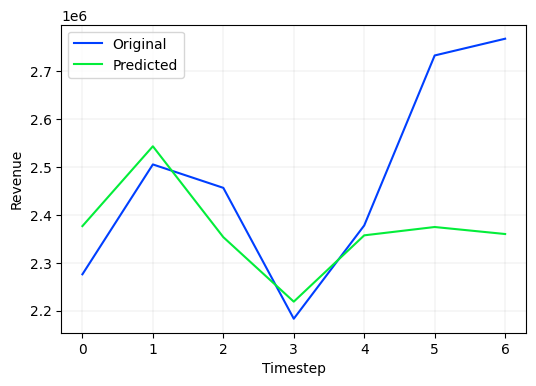

In [103]:
with plt.style.context('seaborn-bright', after_reset=True):
  plt.figure(figsize=(6,4))
  plt.plot(Y_test, label='Original')
  plt.plot(Y_pred, label='Predicted')
  plt.legend()
  plt.xlabel('Timestep')
  plt.ylabel('Revenue')
  plt.grid(color='gray', linestyle='-', linewidth=0.1)
  plt.show()

# Part 2: Bayesian methods

In [8]:
# Define the split date based on the given threshold (e.g., '2016-05-30' in this case)
split_date = '2016-05-30'

# Split the data into train and test sets
train = df[df.DATE <= split_date]
test = df[df.DATE > split_date]

# Extract the target variable 'revenue' from the training and test data
y_train = train['revenue']
y_test = test['revenue']

# Extract the input features from the training and test data
x_train = train.drop(['revenue', 'DATE', 'X'], axis=1)
x_test = test.drop(['revenue', 'DATE', 'X'], axis=1)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

In [59]:
# Define different priors for each feature's weights
priors = {
    'media1_S': {
        'mu': 0,
        'sd': 10
    },
    'media2_S': {
        'mu': 0,
        'sd': 10
    },
    'media3_S': {
        'mu': 0,
        'sd': 10
    },
    'competitor_sales': {
        'mu': 0,
        'sd': 10
    },
    'newsletter': {
        'mu': 0,
        'sd': 10
    }
}

def contruct_bnn(x_input, y_input):
    # Using the context manager to build the model
    with pm.Model() as bnn:
        # Data input
        x_data = pm.MutableData('x_data', x_input)
        y_data = pm.MutableData('y_data', y_input)

        # Model structure
        num_hidden = 5

        # Priors for the weights
        weights = {}

        for feature in x_train.columns:
            weights[feature] = pm.Normal(f'w_{feature}', mu=priors[feature]['mu'], sigma=priors[feature]['sd'], shape=num_hidden)


        b_1 = pm.Normal('b_1', mu=0, sigma=10, shape=num_hidden)
        w_out = pm.Normal('w_out', mu=0, sigma=10, shape=num_hidden)
        b_out = pm.Normal('b_out', mu=0, sigma=10, shape=1)

        # Neural network architecture
        act_1 = pm.math.tanh(pm.math.dot(x_data, pm.math.stack([weights[feature] for feature in x_train.columns])) + b_1)

        act_out = pm.Deterministic('act_out', pm.math.dot(act_1, w_out) + b_out)

        # Likelihood of the data (observed)
        sigma = pm.HalfNormal('sigma', sigma=1)
        likelihood = pm.Normal('Y_obs', mu=act_out, sigma=1, observed=y_data, total_size=y_input.shape[0])

        return bnn

bnn = contruct_bnn(X_train, y_train)
# pm.model_to_graphviz(bnn)

In [60]:
# Specifying the MCMC algorithm (NUTS)
with bnn:
    step = pm.NUTS()
    trace = pm.sample(1000, tune=1000, step=step, chains=4, random_seed=42)

ERROR:pymc:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc:There were 96 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
pm.plot_trace(trace, figsize=(14,10), legend=True, compact=False)
plt.show()

In [62]:
pm.set_data({"x_data": X_test, "y_data": y_test}, model=bnn)

# Generate posterior samples.
ppc_test = pm.sample_posterior_predictive(trace, model=bnn)

# Compute the point prediction by taking the mean
y_test_pred = ppc_test.posterior_predictive['Y_obs'].mean(dim=['chain', 'draw'])

# y_mean = y_test_pred.mean(axis=0)
rmse = mean_squared_error(y_test, y_test_pred, squared = False)
print('RMSE for test dataset = %.5f' % rmse)

RMSE for test dataset = 367191.44063


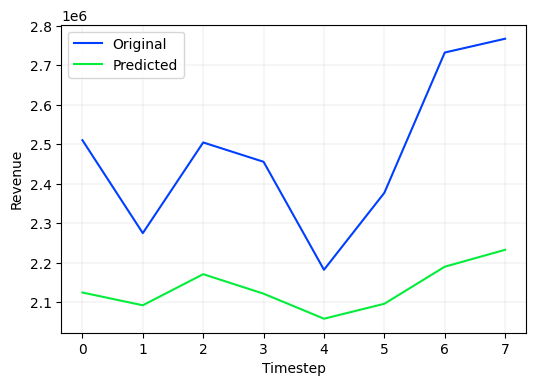

In [63]:
with plt.style.context('seaborn-bright', after_reset=True):
  plt.figure(figsize=(6,4))
  plt.plot(y_test.values, label='Original')
  plt.plot(y_test_pred.values, label='Predicted')
  plt.legend()
  plt.xlabel('Timestep')
  plt.ylabel('Revenue')
  plt.grid(color='gray', linestyle='-', linewidth=0.1)
  plt.show()

In [ ]:
pm.plot_trace(trace, figsize=(14,10), legend=True, compact=False)
plt.show()

In [64]:
pm.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w_media1_S[0],-76.86,753.63,-1213.86,906.34,375.31,287.36,4.31,13.30,4.14
w_media2_S[0],-57.83,401.39,-677.33,445.98,199.89,153.05,4.44,13.45,3.81
w_media3_S[0],-68.01,570.68,-937.22,665.19,284.19,217.60,4.43,11.34,3.44
w_competitor_sales[0],-189.75,1647.93,-2697.36,1930.84,820.66,628.36,4.39,14.31,3.55
w_newsletter[0],-102.47,719.67,-1212.19,802.37,358.39,274.42,4.40,11.36,4.14
...,...,...,...,...,...,...,...,...,...
act_out[195],1605220.65,255843.47,1188651.83,1823008.66,127397.02,97543.87,4.30,11.43,4.11
act_out[196],2003991.33,240606.35,1807010.26,2403356.20,119820.40,91744.19,4.31,11.43,4.03
act_out[197],2061443.03,255830.20,1807010.26,2404514.12,127401.31,97548.62,4.31,11.43,4.07
act_out[198],2075203.86,264890.96,1807010.26,2404706.85,131907.99,100998.55,4.31,11.43,4.08


In [ ]:
# Plotting the ACF plot for the MCMC chains
pm.plot_autocorr(trace)
plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning:

rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (209) in plot_posterior, generating only 40 plots



array([[<Axes: title={'center': 'w_media1_S\n0'}>,
        <Axes: title={'center': 'w_media2_S\n0'}>,
        <Axes: title={'center': 'w_media3_S\n0'}>,
        <Axes: title={'center': 'w_competitor_sales\n0'}>],
       [<Axes: title={'center': 'w_newsletter\n0'}>,
        <Axes: title={'center': 'b_1\n0'}>,
        <Axes: title={'center': 'w_out\n0'}>,
        <Axes: title={'center': 'b_out\n0'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'act_out\n0'}>,
        <Axes: title={'center': 'act_out\n1'}>,
        <Axes: title={'center': 'act_out\n2'}>],
       [<Axes: title={'center': 'act_out\n3'}>,
        <Axes: title={'center': 'act_out\n4'}>,
        <Axes: title={'center': 'act_out\n5'}>,
        <Axes: title={'center': 'act_out\n6'}>],
       [<Axes: title={'center': 'act_out\n7'}>,
        <Axes: title={'center': 'act_out\n8'}>,
        <Axes: title={'center': 'act_out\n9'}>,
        <Axes: title={'center': 'act_out\n10'}>],
       [<Axes: title={

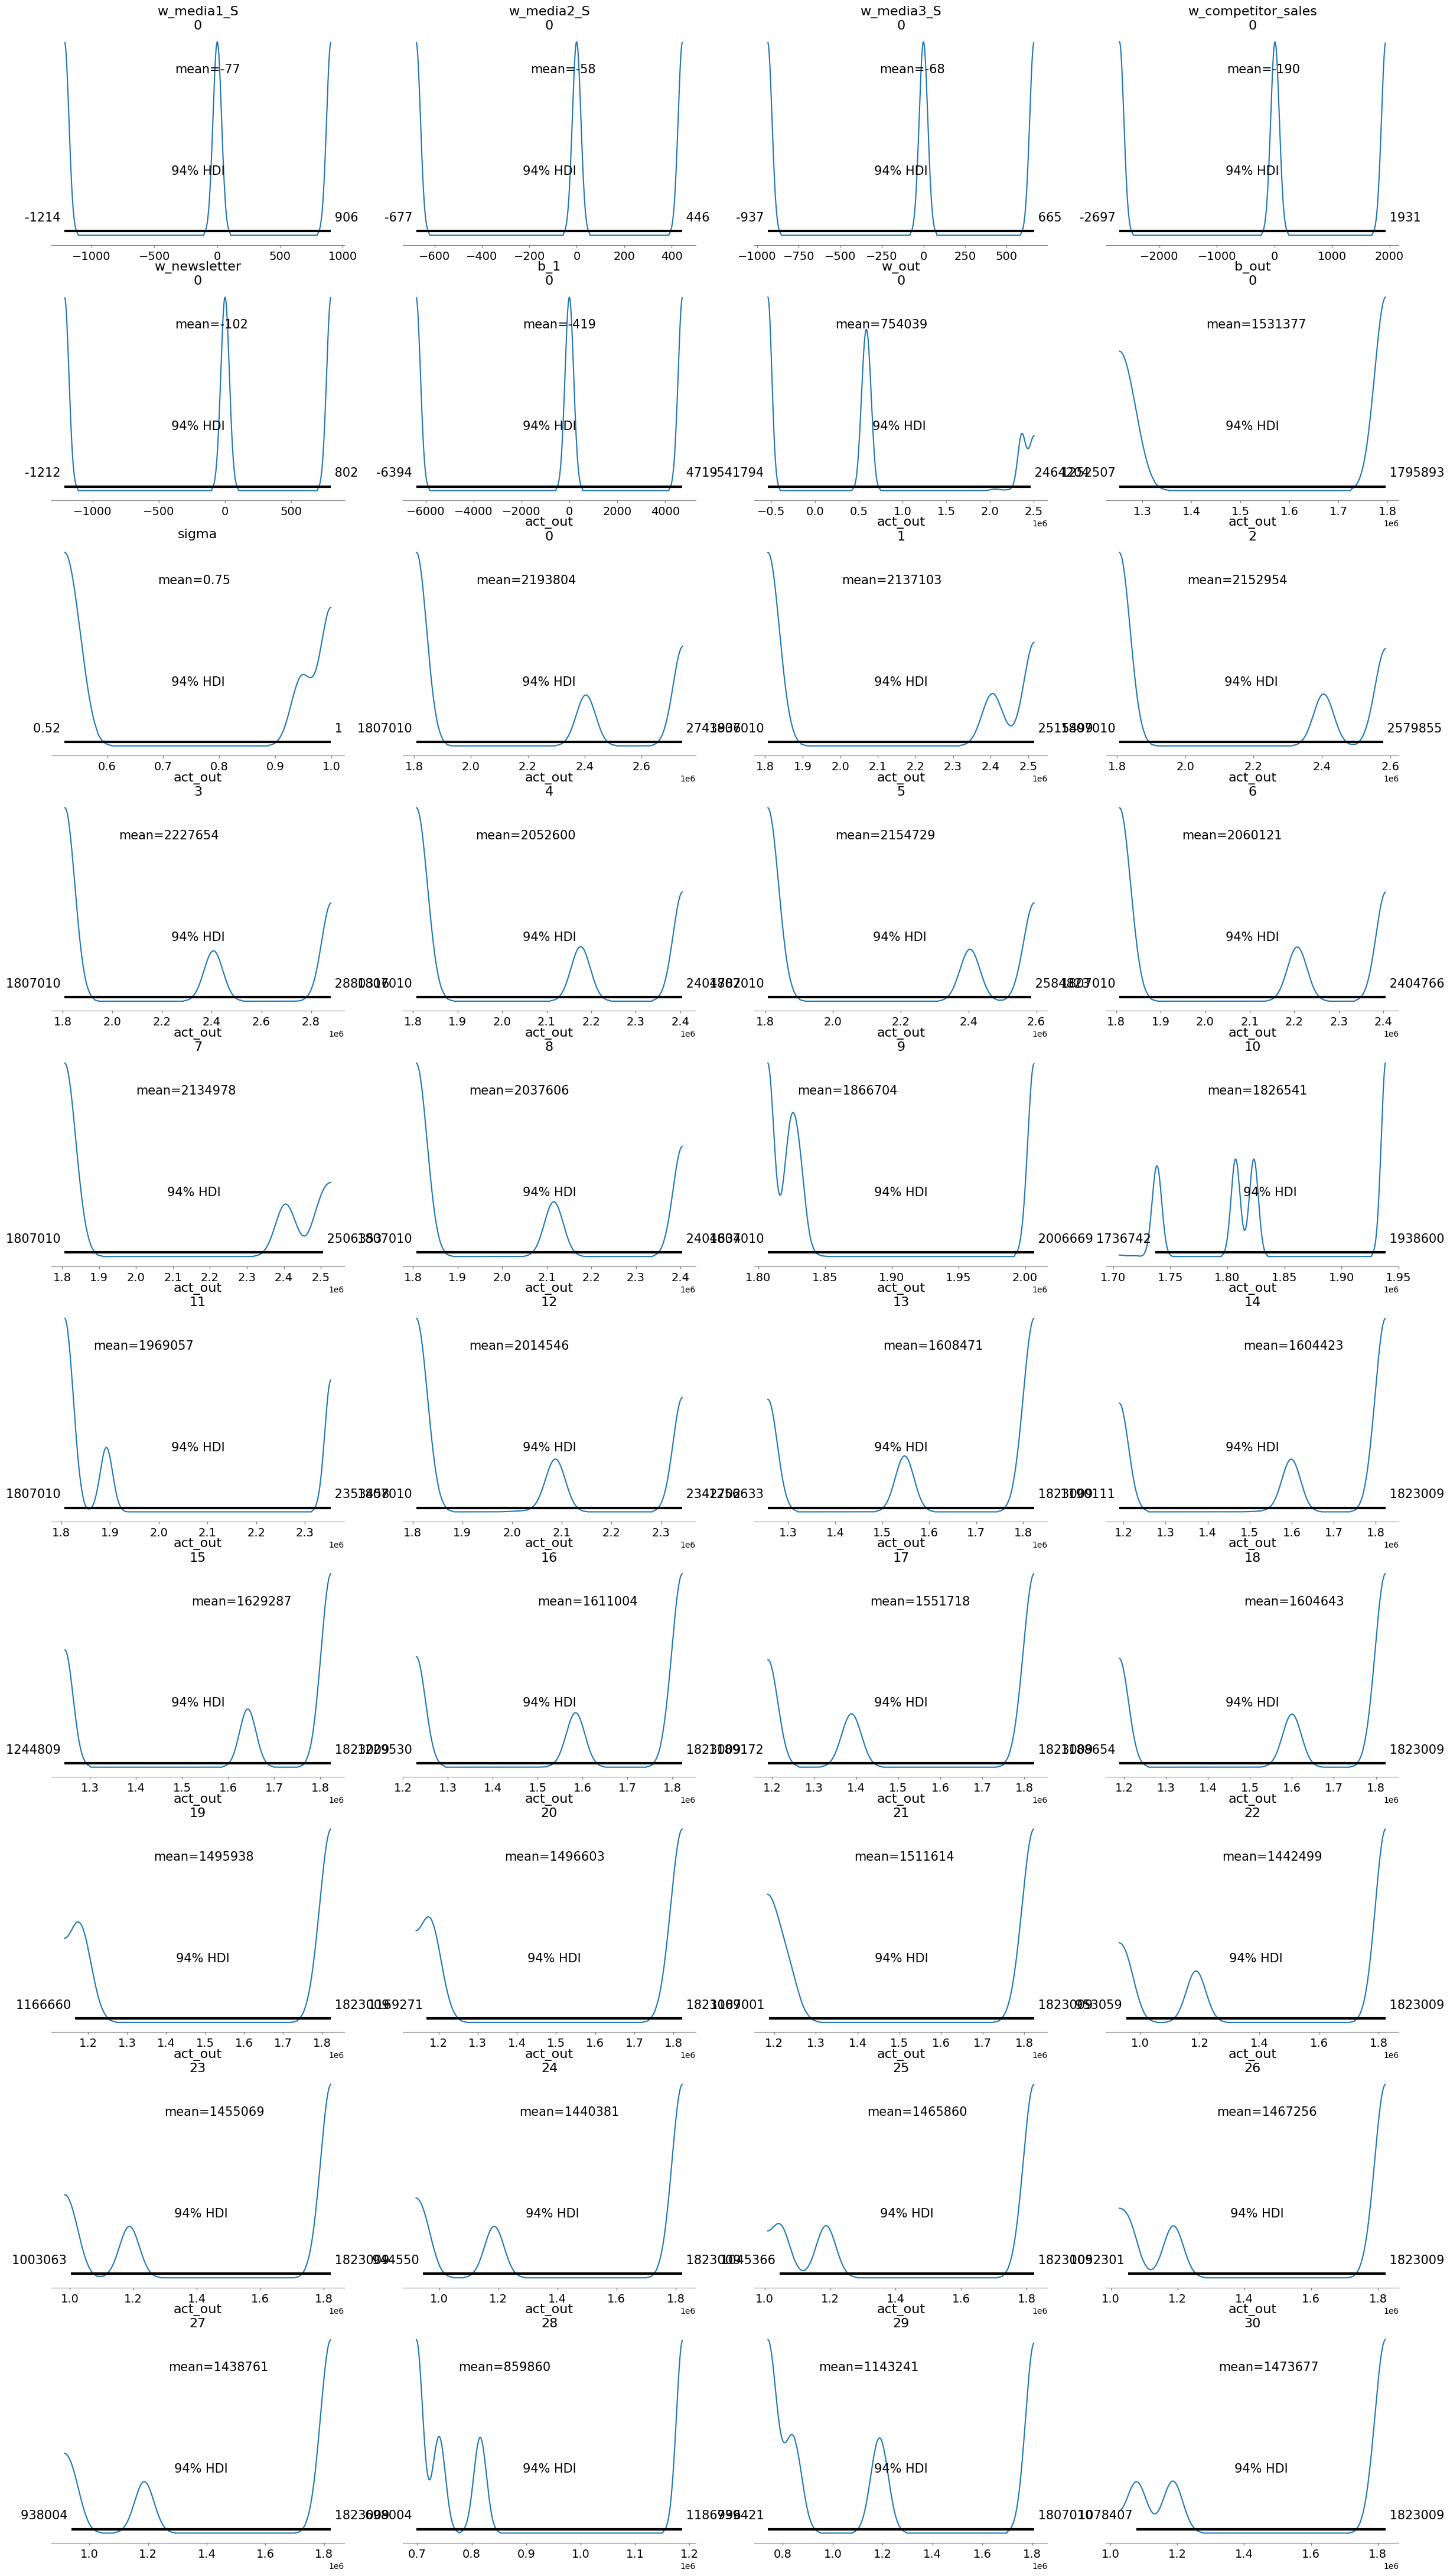

In [66]:
az.plot_posterior(trace)

## Prior Choice

In [67]:
# Define different priors for each feature's weights
priors = {
    'media1_S': {
        'mu': 2,
        'sd': 0.1
    },
    'media2_S': {
        'mu': 8,
        'sd': 0.1
    },
    'media3_S': {
        'mu': 0,
        'sd': 10
    },
    'competitor_sales': {
        'mu': 0.15,
        'sd': 0.05
    },
    'newsletter': {
        'mu': 1,
        'sd': 0.1
    }
}

def contruct_bnn(x_input, y_input):
    # Using the context manager to build the model
    with pm.Model() as bnn:
        # Data input
        x_data = pm.MutableData('x_data', x_input)
        y_data = pm.MutableData('y_data', y_input)

        # Model structure
        num_hidden = 1

        # Priors for the weights
        weights = {}

        for feature in x_train.columns:
            weights[feature] = pm.Normal(f'w_{feature}', mu=priors[feature]['mu'], sigma=priors[feature]['sd'], shape=num_hidden)


        b_1 = pm.Normal('b_1', mu=0, sigma=10, shape=num_hidden)
        w_out = pm.Normal('w_out', mu=0, sigma=10, shape=num_hidden)
        b_out = pm.Normal('b_out', mu=0, sigma=10, shape=1)

        # Neural network architecture
        act_1 = pm.math.tanh(pm.math.dot(x_data, pm.math.stack([weights[feature] for feature in x_train.columns])) + b_1)

        act_out = pm.Deterministic('act_out', pm.math.dot(act_1, w_out) + b_out)

        # Likelihood of the data (observed)
        sigma = pm.HalfNormal('sigma', sigma=1)
        likelihood = pm.Normal('Y_obs', mu=act_out, sigma=1, observed=y_data, total_size=y_input.shape[0])

        return bnn

bnn = contruct_bnn(X_train, y_train)
# pm.model_to_graphviz(bnn)

In [68]:
# Specifying the MCMC algorithm (NUTS)
with bnn:
    step = pm.NUTS()
    trace = pm.sample(1000, tune=1000, step=step, chains=4, random_seed=42)

ERROR:pymc:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


In [69]:
pm.set_data({"x_data": X_test, "y_data": y_test}, model=bnn)

# Generate posterior samples.
ppc_test = pm.sample_posterior_predictive(trace, model=bnn)

# Compute the point prediction by taking the mean
y_test_pred = ppc_test.posterior_predictive['Y_obs'].mean(dim=['chain', 'draw'])

# y_mean = y_test_pred.mean(axis=0)
rmse = mean_squared_error(y_test, y_test_pred, squared = False)
print('RMSE for test dataset = %.5f' % rmse)

RMSE for test dataset = 538757.78733
